In [1]:
from chebGreen import ChebGreen
import numpy as np
import matplotlib.pyplot as plt

from chebGreen.chebpy2 import Quasimatrix
from chebGreen.chebpy2.chebpy import chebfun
from chebGreen.chebpy2 import Chebfun2

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
airy = ChebGreen([1,5,10], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
Dataset for for Theta = 1.00. Skipping dataset generation.
Dataset for for Theta = 5.00. Skipping dataset generation.
Dataset for for Theta = 10.00. Skipping dataset generation.
-------------------------------------------------------------------------------

Generating chebfun2 models:
Found saved model, Loading model for example 'airy_equation' at Theta = 1.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 1.00
Chebfun2 model added for example 'airy_equation' at Theta = 1.00

Found saved model, Loading model for example 'airy_equation' at Theta = 5.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 5.00
Chebfun2 model added for example 'airy_equation' at Theta = 5.00

Found saved model, Loading model for example 'airy_equation' at Theta = 10.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 10.00
Chebfun2 model added for example 'airy_equation' at Theta = 10.00



In [3]:
airy.G

{1.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.238198,
 5.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.138575,
 10.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.087169}

Text(0, 0.5, 's')

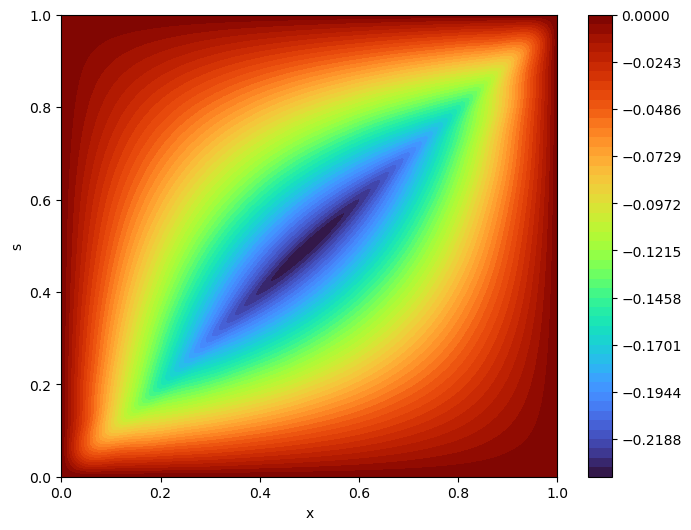

In [4]:
fig = plt.figure(figsize = (8,6))
airy.G[1].plot(fig = fig, ax = plt.gca())
plt.xlabel('x')
plt.ylabel('s')

In [5]:
%%time
u,s,v = airy.G[1].svd()

CPU times: user 5.31 s, sys: 5.35 s, total: 10.7 s
Wall time: 1.8 s


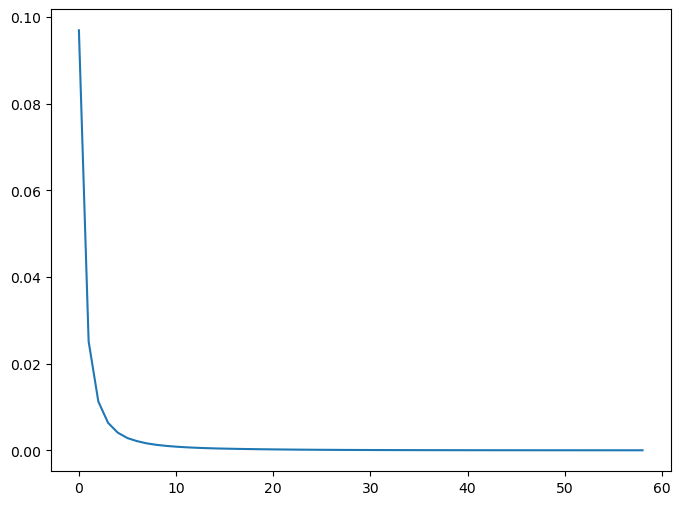

In [7]:
fig = plt.figure(figsize = (8,6))
plt.plot(s)

(0.0, 1.0)

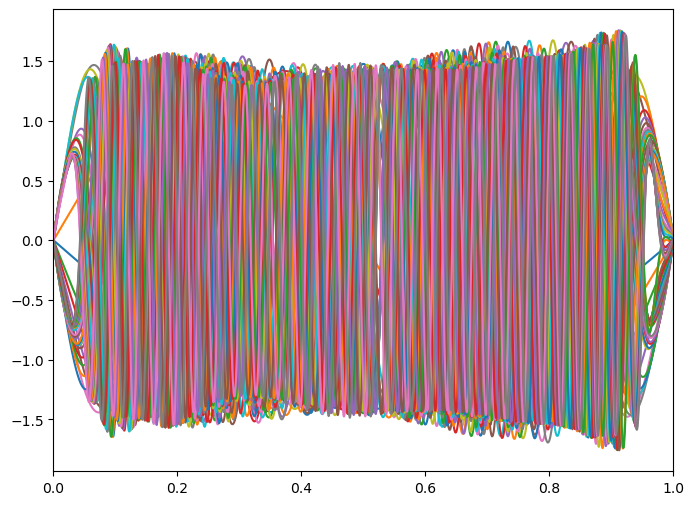

In [8]:
# i = slice(10,20)
i = slice(0,-1)
# i = 16
fig = plt.figure(figsize = (8,6))
u[:,i].plot(fig = fig)
# print(np.max(u[:,i].vscale))
# plt.title(f'First {i+1} left singular functions for a Laplacian')
plt.xlim([0,1])
# fig.savefig(f'Laplace-first.png', dpi = fig.dpi)

In [9]:
def computeInterpCoeffs(interpParams : list, targetParam: float) -> np.array:
    """Computes the interpolation coefficients (based on fitting Lagrange polynomials) for performing interpolation,
    when the parameteric space is 1D. Note that the function takes in parameters of any dimnesions

    --------------------------------------------------------------------------------------------------------------------
    Arguments:
        interpSet: Dictionary of models (Chebfun2 objects) which are used to generate an interoplated model at the
            parameter targetParam.
        targetParam: A float which defines the parameter at which we want to find a new model.

    --------------------------------------------------------------------------------------------------------------------
    Returns:
        A dict of Interpolation coefficents index
    """
    
    assert len(interpParams) > 2, "Need at least two interpolant models"
    assert all([isinstance(theta,float) for theta in interpParams]), \
        "Lagrange Polynomial based interpolation requires the parameteric space to be 1D."

    interpCoeffs = dict([(theta, 1.0) for theta in interpParams])

    for i,t1 in enumerate(interpCoeffs):
        for j,t2 in enumerate(interpCoeffs):
            if i != j:
                interpCoeffs[t1] = interpCoeffs[t1]*((targetParam - t2)/(t1 - t2))

    return interpCoeffs

In [10]:
def compute_order_and_signs(R0: Quasimatrix, R1: Quasimatrix) -> tuple([np.array, np.array]):
    """ Given two orthonormal matrices R0 and R1, this function computes the "correct" ordering and signs of the columns
    (modes) of R1 using R0 as a reference. The assumption is that these are orthonormal matrices, the columns of which
    are eigenmodes of systems which are close to each other and hence the eigenmodes will close to each other as well.
    We thus find an order such that the modes of the second matrix have the maximum inner product (in magnitude) with
    the corresponding mode from the first matrix. If such an ordering doesn't exist the function raises a runtime error.

    Once such an ordering is found, one can flip the signs for the modes of R1, if the inner product is not positive.
    This is necessary when we want to interpolate.

    --------------------------------------------------------------------------------------------------------------------
    Args:
        R0: Orthonormal matrix, the modes of which are used as the reference to re-order and find signs
        R1: Orthonormal matrix for which the modes are supposed to be reordered.

    --------------------------------------------------------------------------------------------------------------------
    Returns:
        New ordering and the signs (sign flips) for matrix R1.
    """
    rank = R0.shape[1]
    order = -1*np.ones(rank).astype(int)
    signs = np.ones(rank)
    
    used = set()
    # For each mode in R1, Search over all modes of R0 for the best matching mode.
    products = np.abs(R0.T * R1) # Compute all the pairwise innerproducts
    for i in range(rank):
        maxidx, maxval = -1, -1
        for j in range(rank):
            current = products[i,j]
            if current >= maxval and (j not in used):
                maxidx = j
                maxval = current
        order[i] = maxidx
        used.add(maxidx)
    
    # Raise an error if the ordering of modes is not a permutation.
    check = set()
    for i in range(rank):
        check.add(order[i])

    if len(check) != rank:
        raise RuntimeError('No valid ordering of modes found')
    
    # Signs are determined according to the correct ordering of modes
    for i in range(rank):
        if (R0[:,i].T * R1[:,int(order[i])]).item() < 0:
            signs[i] = -1
    
    return order, signs

In [42]:
def model_interp(interpSet: dict[float,Chebfun2], targetParam: float) -> Chebfun2:
    """
    Interpolation for the models. The left and right singular functions are interpolated in the tangent space of
    (L^2(domain))^K (K is the model rank) using a QR based retraction map. The singular values are interpolated
    directly (entry-by-entry) using a Lagrange polynomial based inteporlation. Note that currently the interpolation
    only supports 1D parameteric spaces for the model as the method for interpolation within the tangent space only
    supports 1D parameteric spaces but this can be easily extended to higher dimensions. The lifting and retraction to
    the tangent space at an "origin" has no dependendence on the dimensionality of the parameteric space.

    --------------------------------------------------------------------------------------------------------------------
    Arguments:
        interpSet: Dictionary of models (Chebfun2 objects) which are used to generate an interoplated model at the
            parameter targetParam.
        targetParam: A float which defines the parameter at which we want to find a new model.

    --------------------------------------------------------------------------------------------------------------------
    Returns:
        An Chebfun2 object at the target parameter.
    """
    interpParams = list(interpSet.keys())

    assert len(interpParams) > 2, "Need at least two interpolant models"

    # Find the model which is closest to target parameter. Note that the distance is calculated in terms of norm of the
    # normalized parameters.
    
    # models = list(interpSet.values())
    
    refIndex = None
    minDistance = np.inf
    for theta in interpParams:
        distance = np.linalg.norm((theta-targetParam)/targetParam)
        if distance < minDistance:
            minDistance = distance
            refIndex = theta
    
    interpCoeffs = computeInterpCoeffs(interpParams, targetParam)
    
    # Define the origin
    U0, _, Vt0 = interpSet[refIndex].cdr()
    V0 = Vt0.T
    K = interpSet[refIndex].rank
    
    U_ = Quasimatrix(data = chebfun(np.zeros((2,K)), domain = interpSet[refIndex].domain[2:]), transposed = False)
    S_ = np.zeros(K)
    V_ = Quasimatrix(data = chebfun(np.zeros((2,K)), domain = interpSet[refIndex].domain[:2]), transposed = False)
    
    for theta, model in interpSet.items():
        U, S, Vt = model.cdr()
        order, signs = compute_order_and_signs(U0,U)
        
        Uc = U[:,order] * np.diag(signs)
        S = np.diag(S)[order]
        Vc = (Vt.T)[:,order] * np.diag(signs)
        
        # Project to tangent space of model at origin
        Up = Uc - U0 * ((U0.T * Uc + Uc.T * U0)*0.5)
        Vp = Vc - V0 * ((V0.T * Vc + Vc.T * V0)*0.5)
        
        
        # Interpolate the singular functions
        U_ += Up * np.diag(np.ones(K)*interpCoeffs[theta])
        V_ += Vp * np.diag(np.ones(K)*interpCoeffs[theta])
        
        # Interpolate the singular values directly
        S_ += S * interpCoeffs[theta]
        
        
    Un, _ = (U0 + U_).qr()
    Vn, _ = (V0 + V_).qr()
    
    # Match the order and signs with the origin
    order, signs = compute_order_and_signs(U0,Uc)
    Un = Un[:,order] * np.diag(signs)
    Sn = S_[order]
    Vtn = (Vn[:,order] * np.diag(signs)).T
    
    
    return Chebfun2([Un, Sn, Vtn])

In [43]:
%%time
G7 = model_interp(airy.G, 7.0)

CPU times: user 30.6 s, sys: 23.4 s, total: 54 s
Wall time: 8.69 s


In [32]:
airy7 = ChebGreen([7], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
### Example = airy_equation @ theta = 7 ###
Number of samples: 200
Length scale: 0.01
Nf: 250
Nu: 100
Noise: 0%
---------------------------------------
Step = 1/200
Step = 2/200
Step = 3/200
Step = 4/200
Step = 5/200
Step = 6/200
Step = 7/200
Step = 8/200
Step = 9/200
Step = 10/200
Step = 11/200
Step = 12/200
Step = 13/200
Step = 14/200
Step = 15/200
Step = 16/200
Step = 17/200
Step = 18/200
Step = 19/200
Step = 20/200
Step = 21/200
Step = 22/200
Step = 23/200
Step = 24/200
Step = 25/200
Step = 26/200
Step = 27/200
Step = 28/200
Step = 29/200
Step = 30/200
Step = 31/200
Step = 32/200
Step = 33/200
Step = 34/200
Step = 35/200
Step = 36/200
Step = 37/200
Step = 38/200
Step = 39/200
Step = 40/200
Step = 41/200
Step = 42/200
Step = 43/200
Step = 44/200
Step = 45/200
Step = 46/200
Step = 47/200
Step = 48/200
Step = 49/200
Step = 50/200
Step = 51/200
Step = 52/200
Step = 53/200
Step = 54/200
Step = 55/200
Step = 56/200
Step = 57/200
Step = 58/20

In [49]:
xx = np.linspace(0,1,2000)
yy = np.linspace(0,1,2000)
x, y = np.meshgrid(xx,yy)

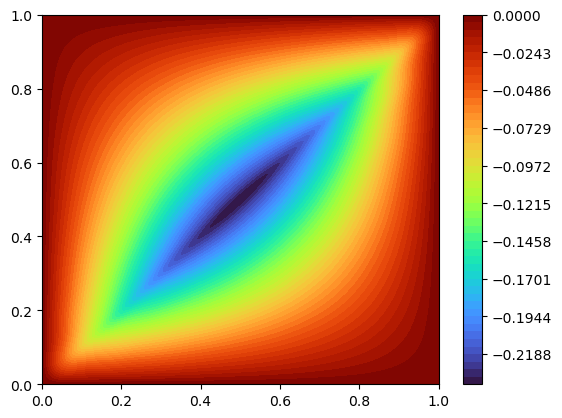

In [55]:
airy.G[1].plot()

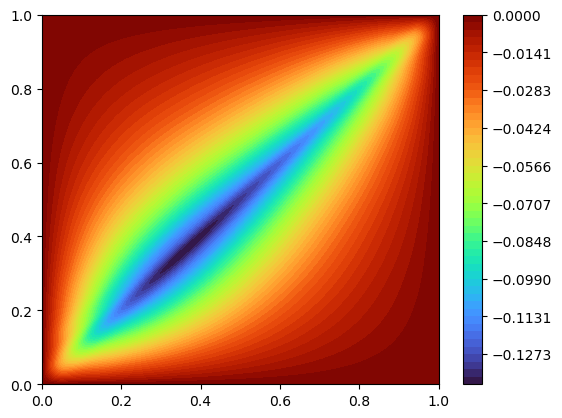

In [56]:
airy.G[5].plot()

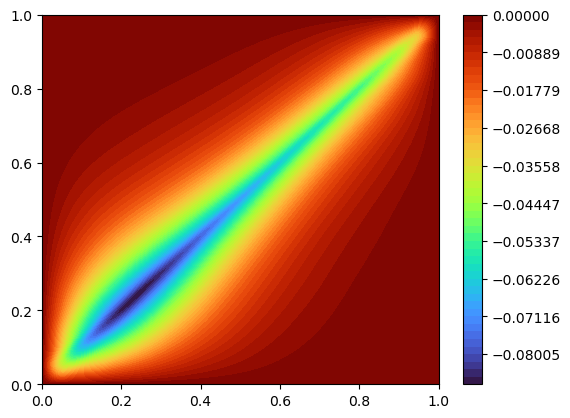

In [57]:
airy.G[10].plot()

In [ ]:
G = G7[x,y]
fig = plt.figure(figsize = (8,6))
vmin, vmax = np.min(G), np.max(G)
plt.contourf(x,y,G, 50, cmap = 'turbo', vmin = vmin, vmax = vmax)
plt.colorbar()
print(np.max(G))
# fig.savefig(f'poisson_greenlearning_chebfun2.png', dpi = fig.dpi)

-0.10868631154676421


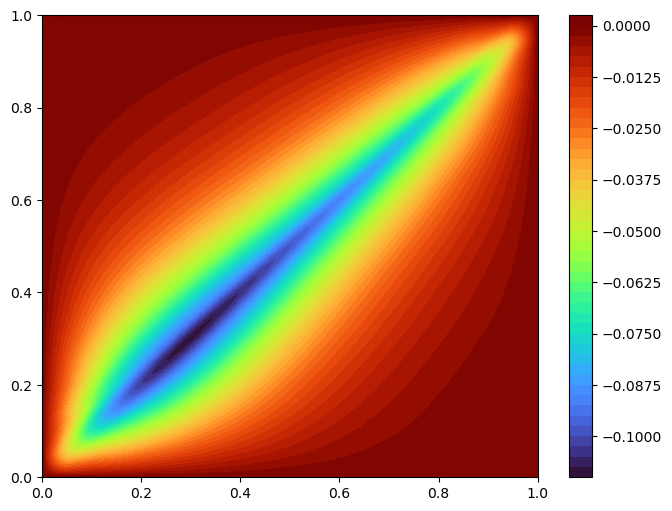

In [58]:
G = G7[x,y]
fig = plt.figure(figsize = (8,6))
vmin, vmax = np.min(G), np.max(G)
plt.contourf(x,y,G, 50, cmap = 'turbo', vmin = vmin, vmax = vmax)
plt.colorbar()
print(np.min(G))
# fig.savefig(f'poisson_greenlearning_chebfun2.png', dpi = fig.dpi)

-0.11172064195056348


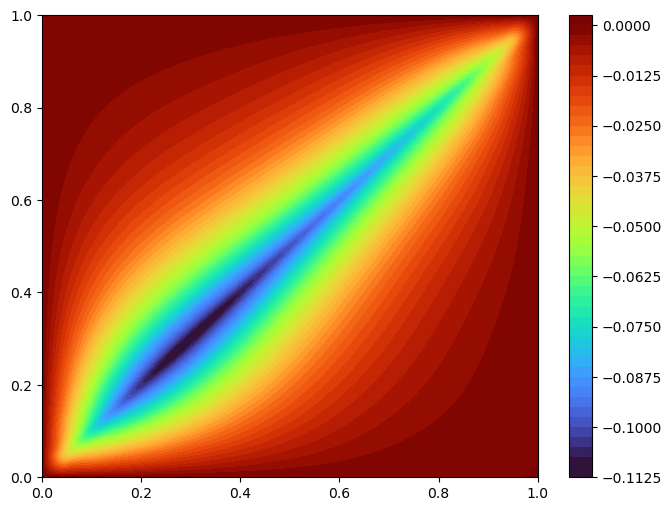

In [59]:
G = (airy7.G[7])[x,y]
fig = plt.figure(figsize = (8,6))
# vmin, vmax = np.min(G), np.max(G)
plt.contourf(x,y,G, 50, cmap = 'turbo', vmin = vmin, vmax = vmax)
plt.colorbar()
print(np.min(G))
# fig.savefig(f'poisson_greenlearning_chebfun2.png', dpi = fig.dpi)